In [91]:
pip install monai

Note: you may need to restart the kernel to use updated packages.


In [226]:
from monai.utils import first
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    Resized,
    ToTensord,
    ScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    Flipd,
    RandAffined,
)


from monai.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import os
import torch
import nibabel as nib
from tqdm import tqdm
import re

In [258]:
def save_nifti(in_image, in_label, out, index = 0):

    volume = np.array(in_image.detach().cpu()[0, :, :, :], dtype=np.uint16)
    lab = np.array(in_label.detach().cpu()[0, :, :, :], dtype=np.uint16)
    if volume.shape != lab.shape:
        print(f"Пропущена пара с индексом {index} из-за несоответствия размеров: {volume.shape} и {lab.shape}")
        return

    
    volume = np.squeeze(volume)
    lab = np.squeeze(lab)
 
    volume = nib.Nifti1Image(volume, np.eye(4))
    lab = nib.Nifti1Image(lab, np.eye(4))
    # print(in_label)
   
    path_out_images = os.path.join(out, 'Images')
    path_out_labels = os.path.join(out, 'Labels')

    # label = dfsdfin_image.split('_')[-1].split('.')[0]

   
    if not os.path.exists(path_out_images):
        os.mkdir(path_out_images)
    if not os.path.exists(path_out_labels):
        os.mkdir(path_out_labels)

    
    
    path_data = os.path.join(out, 'Images')
    path_label = os.path.join(out, 'Labels')
    nib.save(volume, os.path.join(path_data, f'patient_generated_{index}.nii'))
    nib.save(lab, os.path.join(path_label, f'patient_generated_{index}.nii'))

    print(f'patient_generated_{index} is saved', end='\r')

In [259]:
data_dir = './all_together'
train_images = sorted(glob.glob(os.path.join(data_dir, "TrainData0", "*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "TrainLabels0", "*.nii")))

train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

In [260]:
def extract_index(filename):
    match = re.search(r'(\d+)', os.path.basename(filename))
    return int(match.group(1)) if match else None


image_dict = {extract_index(img): img for img in train_images}
label_dict = {extract_index(lbl): lbl for lbl in train_labels}


train_files = [{"image": image_dict[idx], "label": label_dict[idx]} 
               for idx in sorted(image_dict.keys()) if idx in label_dict]

# print(train_files)

In [261]:
# train_files

In [262]:
original_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,),
        ToTensord(keys=["image", "label"]),
    ]
)

In [263]:
generat_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True,),
        # RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10),
        # RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.1),
        ToTensord(keys=["image", "label"]),
    ]
)

In [270]:
original_ds = Dataset(data=train_files, transform=original_transforms)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

_______________________________________________________________________________________________________

# Display the original patient and the generated one

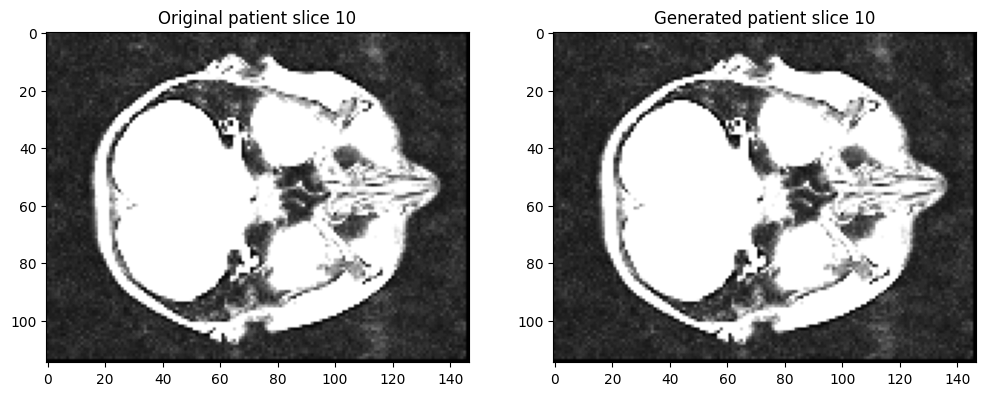

In [265]:
number_slice = 10
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["image"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["image"][0, 0, :, :, number_slice], cmap="gray")


plt.show()

_______________________________________________________________________________________________________

# Save the generated patients


In [266]:

# os.makedirs(output_path, exist_ok=True)

In [276]:
train_files

[{'image': './all_together/TrainData0/Person1.nii',
  'label': './all_together/TrainLabels0/Person1_label.nii'},
 {'image': './all_together/TrainData0/Person2.nii',
  'label': './all_together/TrainLabels0/Person2_label.nii'},
 {'image': './all_together/TrainData0/Person3.nii',
  'label': './all_together/TrainLabels0/Person3_label.nii'},
 {'image': './all_together/TrainData0/Person4.nii',
  'label': './all_together/TrainLabels0/Person4_label.nii'},
 {'image': './all_together/TrainData0/Person5.nii',
  'label': './all_together/TrainLabels0/Person5_label.nii'},
 {'image': './all_together/TrainData0/Person6.nii',
  'label': './all_together/TrainLabels0/Person6_label.nii'},
 {'image': './all_together/TrainData0/Person7.nii',
  'label': './all_together/TrainLabels0/Person7_label.nii'},
 {'image': './all_together/TrainData0/Person8.nii',
  'label': './all_together/TrainLabels0/Person8_label.nii'},
 {'image': './all_together/TrainData0/Person9.nii',
  'label': './all_together/TrainLabels0/Pers

In [277]:
output_path = './all_together/generation 3/gen_data_0_0'
# os.makedirs(output_path, exist_ok=True)
number_runs = 1
matching_dict = {}
for i in range(number_runs):
    name_folder = 'generated_data_' + str(i) 

    if (not os.path.isdir(os.path.join(output_path, name_folder))):
        os.mkdir(os.path.join(output_path, name_folder))
    output = os.path.join(output_path, name_folder)
    
    check_ds = Dataset(data=train_files, transform=generat_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    check_data = first(check_loader)
    for index, patient in enumerate(check_loader):
        original_file = train_files[index]['image']
        generated_file = os.path.join(output, 'Images', f'patient_generated_{index}.nii')
        matching_dict[generated_file] = original_file
        # image = patient['image']
        # label = patient['label']
        

        # image = np.squeeze(image)
        # label = np.squeeze(label)
    #         volume = np.squeeze(volume)
    # lab = np.squeeze(lab)
 
        # image = nib.Nifti1Image(image, np.eye(4))
        # label = nib.Nifti1Image(label, np.eye(4))
        
        save_nifti(patient['image'], patient['label'], output, index)
    print(f'step {i} done')
for generated, original in matching_dict.items():
    print(f"Generated file: {generated} corresponds to Original file: {original}")


step 0 doneerated_23 is saved
Generated file: ./all_together/generation 3/gen_data_0_0/generated_data_0/Images/patient_generated_0.nii corresponds to Original file: ./all_together/TrainData0/Person1.nii
Generated file: ./all_together/generation 3/gen_data_0_0/generated_data_0/Images/patient_generated_1.nii corresponds to Original file: ./all_together/TrainData0/Person2.nii
Generated file: ./all_together/generation 3/gen_data_0_0/generated_data_0/Images/patient_generated_2.nii corresponds to Original file: ./all_together/TrainData0/Person3.nii
Generated file: ./all_together/generation 3/gen_data_0_0/generated_data_0/Images/patient_generated_3.nii corresponds to Original file: ./all_together/TrainData0/Person4.nii
Generated file: ./all_together/generation 3/gen_data_0_0/generated_data_0/Images/patient_generated_4.nii corresponds to Original file: ./all_together/TrainData0/Person5.nii
Generated file: ./all_together/generation 3/gen_data_0_0/generated_data_0/Images/patient_generated_5.nii 

In [268]:
os.getcwd()

'/Users/viktoria.nam/yacamp/project'

In [275]:
# Путь к директории с сгенерированными данными
output_path = './all_together/generation_3/gen_data_0_0'

# Количество запусков генерации
number_runs = 1

# Словарь для хранения сопоставлений
matching_dict = {}

for i in range(number_runs):
    name_folder = 'generated_data_' + str(i)
    output = os.path.join(output_path, name_folder)

    # Подготовка датасета и загрузчика
    check_ds = Dataset(data=train_files, transform=generat_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)

    # Итерация по сгенерированным данным
    for index, patient in enumerate(check_loader):
        # Получение исходного файла
        original_file = train_files[index]['image']

        # Формирование имени сгенерированного файла
        generated_file = os.path.join(output, 'Images', f'patient_generated_{index}.nii')

        # Сохранение сопоставления
        matching_dict[generated_file] = original_file

# Вывод сопоставлений
for generated, original in matching_dict.items():
    print(f"Generated file: {generated} corresponds to Original file: {original}")


Generated file: ./all_together/generation_3/gen_data_0_0/generated_data_0/Images/patient_generated_0.nii corresponds to Original file: ./all_together/TrainData0/Person1.nii
Generated file: ./all_together/generation_3/gen_data_0_0/generated_data_0/Images/patient_generated_1.nii corresponds to Original file: ./all_together/TrainData0/Person2.nii
Generated file: ./all_together/generation_3/gen_data_0_0/generated_data_0/Images/patient_generated_2.nii corresponds to Original file: ./all_together/TrainData0/Person3.nii
Generated file: ./all_together/generation_3/gen_data_0_0/generated_data_0/Images/patient_generated_3.nii corresponds to Original file: ./all_together/TrainData0/Person4.nii
Generated file: ./all_together/generation_3/gen_data_0_0/generated_data_0/Images/patient_generated_4.nii corresponds to Original file: ./all_together/TrainData0/Person5.nii
Generated file: ./all_together/generation_3/gen_data_0_0/generated_data_0/Images/patient_generated_5.nii corresponds to Original file: 